## 주요 변동사항

### 가. 피처

* w2v 기법을 사용하여 변수 생성하였습니다. 자체 성능평가 결과 성능이 우수한 딥러닝 모델으로 학습시켰습니다.

* smoothing 인코딩한 변수를 추가해보고 가우시안 노이즈 기법을 사용하였으나 성능이 개선되지 않았습니다.
* 이상치 제거 및 다양한 정규화 기법을 적용하였으며 MinmaxScaler()를 사용하였습니다.

### 나. 파이프라인

* 딥러닝 모델과 데이터 셋의 관계를 확인하기 위해서 동일한 파라미터를 가진 모델 5개와 5개의 개별 데이터 셋을 준비하였습니다.
* StratifiedKFold(cv = 7)를 사용하였으며, 안정적인 튜닝을 위하여 Stratify한 train_test_split을 사용하여 데이터 셋을 train, valid, test로 나누어 학습시키고 k-fold한 결과를 종합하여 제출하였습니다.

In [1]:
%run import_modules.py  
%matplotlib inline

# For DNN modeling
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.initializers import *
from tensorflow.keras.regularizers import *
from tensorflow.keras.utils import * # model_to_dot, to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.text import *

# Tensorflow warning off
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

In [2]:
SEED = 10334            # seed 숫자를 지정
random.seed(SEED)     # Python 고정
np.random.seed(SEED)  # numpy 고정
tf.random.set_seed(SEED) # Tensorflow 고정

In [ ]:
%%writefile w2v11.py


import pandas as pd
import numpy as np

df_train = pd.read_csv('X_train.csv', encoding='cp949')
df_test = pd.read_csv('X_test.csv', encoding='cp949')
y_train = pd.read_csv('y_train.csv').gender
IDtest = df_test.cust_id.unique()
f_data = pd.concat([df_train, df_test]).reset_index(drop=True)

### Make corpus
p_level = 'gds_grp_nm'  # 상품 분류 수준

# oversampling
def oversample(x, n, seed=0):
    if n == 0:
        return list(x)
    uw = np.unique(x)
    bs = np.array([])
    np.random.seed(seed)
    for j in range(n):
        bs = np.append(bs, np.random.choice(uw, len(uw), replace=False))
    return list(bs)

X_train = list(df_train.groupby('cust_id')[p_level].agg(oversample, 20))
X_test = list(df_test.groupby('cust_id')[p_level].agg(oversample, 20))
F_data = list(f_data.groupby('cust_id')[p_level].agg(oversample,20))

# Training the Word2Vec model
num_features = 100 # 벡터 차원 수
min_word_count = 1 # 최소 단어 수
context = 5 # 학습 윈도우 크기

# 초기화 및 모델 학습
from gensim.models import word2vec

# 모델 학습
w2v = word2vec.Word2Vec(F_data, 
                        size=num_features, 
                        min_count=min_word_count,
                        window=context,
                        seed=0, workers=4, sg=0)

# 필요없는 메모리 unload
w2v.init_sims(replace=True)

vocabs = w2v.wv.vocab.keys()
vocab_vectors_list = [w2v.wv[v] for v in vocabs]

word_embeddings = pd.DataFrame(w2v.wv.syn0norm[:, :], index=w2v.wv.index2word[:])

F = f_data[['cust_id','gds_grp_nm']]

train_test = pd.merge(left = F, right = word_embeddings, left_on='gds_grp_nm', right_index=True,how='left')
train_test = train_test.drop(['gds_grp_nm'], axis=1)

m = pd.DataFrame(train_test['cust_id'].unique())
m.rename(columns={0:'cust_id'},inplace=True)

for i in range(100) :
    s = train_test.groupby('cust_id')[i].agg([
        (f'{i}.min',np.min)]).reset_index()
    m = pd.merge(left = m,right = s,on='cust_id',how='outer')

mx = pd.DataFrame(train_test['cust_id'].unique())
mx.rename(columns={0:'cust_id'},inplace=True)

for i in range(100) :
    s = train_test.groupby('cust_id')[i].agg([
        (f'{i}.max',np.max)]).reset_index()
    mx = pd.merge(left = mx,right = s,on='cust_id',how='outer')

mn = pd.DataFrame(train_test['cust_id'].unique())
mn.rename(columns={0:'cust_id'},inplace=True)

for i in range(100) :
    s = train_test.groupby('cust_id')[i].agg([
        (f'{i}.mean',np.mean)]).reset_index()
    mn = pd.merge(left = mn,right = s,on='cust_id',how='outer')

ss = pd.DataFrame(train_test['cust_id'].unique())
ss.rename(columns={0:'cust_id'},inplace=True)

for i in range(100) :
    s = train_test.groupby('cust_id')[i].agg([
        (f'{i}.sum',np.sum)]).reset_index()
    ss = pd.merge(left = ss,right = s,on='cust_id',how='outer')

st = pd.DataFrame(train_test['cust_id'].unique())
st.rename(columns={0:'cust_id'},inplace=True)

for i in range(100) :
    s = train_test.groupby('cust_id')[i].agg([
        (f'{i}.std',np.std)]).reset_index()
    st = pd.merge(left = st,right = s,on='cust_id',how='outer')
st = st.fillna(0)
# 데이터 병합
train_test = pd.merge(m,mx, on='cust_id', how='outer')
train_test = pd.merge(train_test,mn, on='cust_id', how='outer')
train_test = pd.merge(train_test,ss, on ='cust_id', how='outer')
train_test = pd.merge(train_test,st, on = 'cust_id', how='outer')

train_test.to_csv('w2v0611.csv',index=False)

In [ ]:
import os
import subprocess

subprocess.run(['python', 'w2v11.py'], env={**os.environ, 'PYTHONHASHSEED': '123'})

### Read Data

In [3]:
train_test = pd.read_csv('w2v0611.csv', encoding='cp949')
# df_train = pd.read_csv('X_train.csv', encoding='cp949')
df_test = pd.read_csv('X_test.csv', encoding='cp949')
y_train = pd.read_csv('y_train.csv').gender
IDtest = df_test.cust_id.unique()

### Data PreProcessing

In [4]:
train_test.iloc[:,1:] = train_test.iloc[:,1:].apply(lambda x: x.clip(x.quantile(.05), x.quantile(.95)), axis=0)
train_test.iloc[:,1:] = train_test.iloc[:,1:] + 1

from sklearn.preprocessing import RobustScaler
# from sklearn.preprocessing import Normalizer

scaler = MinMaxScaler()
# scaler = RobustScaler()
# scaler = Normalizer()

train_test.iloc[:,1:] = scaler.fit_transform(train_test.iloc[:,1:])

train_w2v = train_test.query('cust_id not in @IDtest').drop('cust_id', axis=1)
test_w2v = train_test.query('cust_id in @IDtest').drop('cust_id', axis=1)

train_w2v = np.array(train_w2v)
X_test = np.array(test_w2v)

### Build Models with W2V

In [5]:
folds = StratifiedKFold(n_splits=7,
                        shuffle=True, 
                        random_state=1)

index_info = []

# cv의 train과 valid index를 저장

for fold_, (trn_, val_) in enumerate(folds.split(y_train, y_train)):
    
    index_info.append([trn_, val_])

In [6]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

callback_list = [
    
    EarlyStopping(
        
        patience = 7
    ),
    
    ReduceLROnPlateau(
        
        factor = 0.1,
        patience = 5,
    )
]

  0%|                                                                                            | 0/7 [00:00<?, ?it/s]

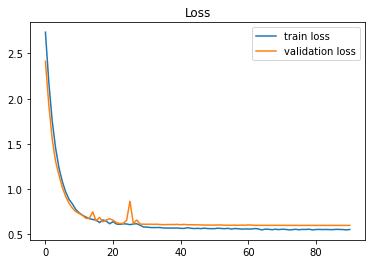

AUC 0.754799168030551


 14%|████████████                                                                        | 1/7 [00:15<01:35, 15.96s/it]

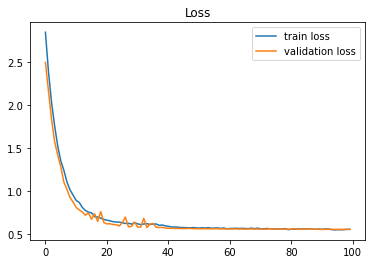

 29%|████████████████████████                                                            | 2/7 [00:33<01:22, 16.57s/it]

AUC 0.7183834560829243


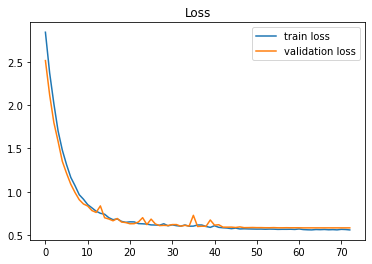

AUC 0.7567171303873432


 43%|████████████████████████████████████                                                | 3/7 [00:45<01:00, 15.18s/it]

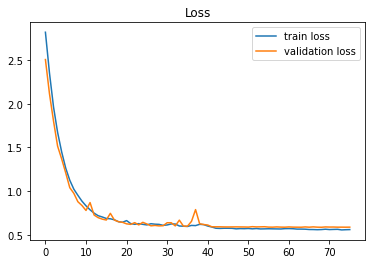

AUC 0.765284028914348


 57%|████████████████████████████████████████████████                                    | 4/7 [00:59<00:44, 14.68s/it]

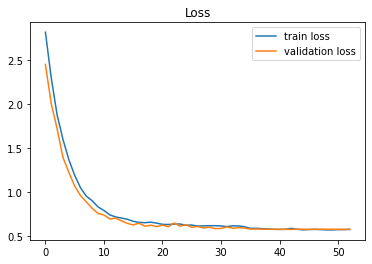

AUC 0.7832105837424986


 71%|████████████████████████████████████████████████████████████                        | 5/7 [01:11<00:27, 13.88s/it]

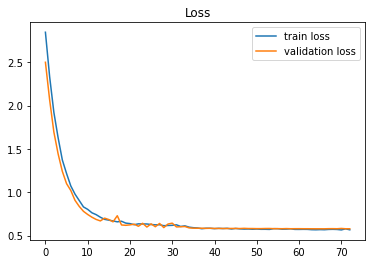

AUC 0.7724699945444626


 86%|████████████████████████████████████████████████████████████████████████            | 6/7 [01:27<00:14, 14.58s/it]

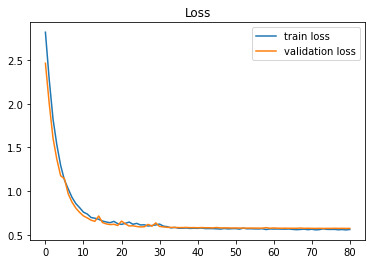

AUC 0.7471784642662304


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [01:43<00:00, 14.84s/it]


Validation Summary:
4    0.783211
5    0.772470
3    0.765284
2    0.756717
0    0.754799
6    0.747178
1    0.718383
dtype: float64
mean=0.75686, std=0.021


In [7]:
N = 7
p = 3.5
preds = []
aucs = []

n_size = 500 

for i in tqdm(range(N)):
    
    #### STEP 1:  Train, Validation, test 데이터 분할
        
    fold_ = i

    trn_ = index_info[fold_][0]
    tst_ = index_info[fold_][1]

    trn_x, trn_y = train_w2v[trn_], y_train[trn_]
    tst_x, tst_y = train_w2v[tst_], y_train[tst_]

    trn_x, val_x, trn_y, val_y = train_test_split(trn_x, trn_y, test_size = n_size, stratify = trn_y)

    ##### STEP 2: Build a DNN Model
    
    # Define the number of features
    max_features = trn_x.shape[1]

    # Define the model architecture
    model = Sequential()
    model.add(Dense(64, activation='elu', input_shape=(max_features,), kernel_regularizer=l2(0.02)))
    model.add(Dropout(0.35))
    model.add(Dense(32, activation='elu'))
    model.add(Dropout(0.35))
    model.add(Dense(16, activation='elu'))
    model.add(Dropout(0.33))
    model.add(Dense(1, activation='sigmoid'))

    # Train the model

    model.compile(optimizer='nadam', loss='binary_crossentropy', metrics=['acc'])
    history = model.fit(trn_x, trn_y, epochs=100, validation_data=(val_x, val_y),
                          batch_size = 128, callbacks = callback_list, verbose = 0)

    plt.plot(history.history["loss"], label="train loss")
    plt.plot(history.history["val_loss"], label="validation loss")
    plt.legend()
    plt.title("Loss")
    plt.show()

    auc = roc_auc_score(tst_y, model.predict(tst_x).flatten())
    aucs.append(auc)
    print('AUC', auc)
    preds.append(model.predict(X_test).flatten())  

### Validate the Models
print('\nValidation Summary:')
aucs = pd.Series(aucs)
print(aucs.sort_values(ascending=False))
print('mean={:.5f}, std={:.3f}'.format(aucs.mean(), aucs.std()))     

In [8]:
# Power mean ensemble
THRESHOLD = 0.76  # Use only models whose AUC exceeds this value

pred = 0
n = 0
for i in range(N):
    if aucs.iloc[i] > THRESHOLD:
        pred = pred + preds[i]**p 
        n += 1
pred = pred / n    
pred = pred**(1/p)

# Make a submission file
t = pd.Timestamp.now()
fname = f"dae_p{p}n{n}_submit_{t.month:02}{t.day:02}{t.hour:02}{t.minute:02}.csv"
submissions = pd.concat([pd.Series(IDtest, name="cust_id"), pd.Series(pred, name="gender")] ,axis=1)
submissions.to_csv(fname, index=False)
print(f"'{fname}' is ready to submit.")

'dae_p3.5n3_submit_06112310.csv' is ready to submit.
